<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# Preliminaries

In [1]:
# set directory
%cd '/Users/philine/Documents/GitHub/CML/mimic_icu_knn_svm/'

/Users/philine/Documents/GitHub/CML/mimic_icu_knn_svm


In [2]:
# import relevant packages
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.pipeline import Pipeline

from utils.helper_functions import *

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Preprocessing

In [3]:
# Training dataset
data=pd.read_csv('data/mimic_train.csv')
data.head()
#data.info()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [4]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('data/mimic_test_death.csv')
data_test.sort_values('icustay_id').head()
#data_test.info()

# Note test data has fewer columns than train data

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [5]:
# Sample output prediction file
pred_sample=pd.read_csv('data/mimic_kaggle_death_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
1937,200011,0
4908,200044,0
829,200049,0
4378,200063,0
4946,200081,0


## Incorporate comorbidities into the data set

For incorporating the comorbidity data I looked for a way that would retain as much information as possible, whilst not drastically increasing the dimensionality of the main dataset. I tried the following three approaches:

1. Count the number of comorbidities of each patient
2. Make dummies for parent ICD9 categories as specified on wikipedia: https://en.wikipedia.org/wiki/List_of_ICD-9_codes. For each patient count the number of comorbidities within each parent group. Complement this with dummies for the 10 most frequent comorbidities.
3. Construct a 'mortality proxy' for each ICD9 code by combining the comorbidity data with the HOSPITAL_EXPIRE_FLAG. This yields the share of patients with a particular comorbidity who died. This 'mortality proxy' can be merged back to the main dataset on ICD9 codes. Further add the mean and max probability of dying associated with the comorbidities for each patient.

Approach 1 has the highest information loss. Approach 2 was an improvement on 1, but failed to account for the different severities of diseases within each parent category. I thus chose the third option, as this yielded the best results.

In [6]:
# Load comorbidity data
comorbidity = pd.read_csv('data/extra_data/MIMIC_diagnoses.csv')
comorbidity.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [7]:
comorbidity.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [8]:
# Reformat columns
comorbidity = comorbidity.rename(columns=str.lower)
comorbidity = comorbidity.dropna()
comorbidity.head()

,subject_id,hadm_id,seq_num,icd9_code
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


### Target encode comorbidity data with proxy for mortality

In [9]:
# Merge HOSPITAL_EXPIRE_FLAG to comorbidity dataset
comorbidity = pd.merge(left=comorbidity,
                       right=data[['subject_id', 'hadm_id', 'HOSPITAL_EXPIRE_FLAG']],
                       how='left',
                       on=['subject_id', 'hadm_id'])

comorbidity.head()

,subject_id,hadm_id,seq_num,icd9_code,HOSPITAL_EXPIRE_FLAG
0,256,108811,1.0,53240,0.0
1,256,108811,2.0,41071,0.0
2,256,108811,3.0,53560,0.0
3,256,108811,4.0,40390,0.0
4,256,108811,5.0,5859,0.0


In [10]:
comorbidity['HOSPITAL_EXPIRE_FLAG'].describe()

count    309894.000000
mean          0.141539
std           0.348577
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64

In [11]:
# Construct the mortality proxy for each ICD9 code
mortality_proxy = comorbidity.groupby('icd9_code')['HOSPITAL_EXPIRE_FLAG'].mean().reset_index()
mortality_proxy = mortality_proxy.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'mortality_proxy', 'icd9_code': 'ICD9_diagnosis'})
mortality_proxy.head()

,ICD9_diagnosis,mortality_proxy
0,0030,0.0
1,0031,0.0
2,0038,0.0
3,0039,0.0
4,0041,0.0


(array([3672.,  782.,  410.,  172.,   50.,  135.,   24.,   10.,    7.,
         127.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

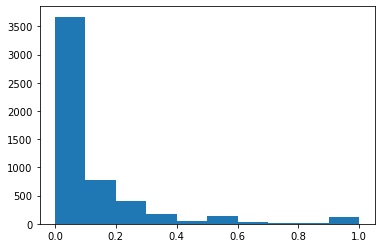

In [12]:
plt.hist(mortality_proxy['mortality_proxy'])

In [13]:
# For each patient, compute mean and max probability of dying associated with the comorbidities
comorbidity['mortality_proxy'] = comorbidity['HOSPITAL_EXPIRE_FLAG'].groupby(comorbidity['icd9_code']).transform('mean')
comorbidity['max_mortality'] = comorbidity['mortality_proxy'].groupby(comorbidity['subject_id']).transform('max')
comorbidity['mean_mortality'] = comorbidity['mortality_proxy'].groupby(comorbidity['subject_id']).transform('mean')
comorbidity.head(10)

,subject_id,hadm_id,seq_num,icd9_code,HOSPITAL_EXPIRE_FLAG,mortality_proxy,max_mortality,mean_mortality
0,256,108811,1.0,53240,0.0,0.130719,0.37931,0.13077
1,256,108811,2.0,41071,0.0,0.140284,0.37931,0.13077
2,256,108811,3.0,53560,0.0,0.080808,0.37931,0.13077
3,256,108811,4.0,40390,0.0,0.135878,0.37931,0.13077
4,256,108811,5.0,5859,0.0,0.139289,0.37931,0.13077
5,256,108811,6.0,04186,0.0,0.103448,0.37931,0.13077
6,256,108811,7.0,41401,0.0,0.087152,0.37931,0.13077
7,256,108811,8.0,2724,0.0,0.088111,0.37931,0.13077
8,256,108811,9.0,496,0.0,0.146394,0.37931,0.13077
9,256,108811,10.0,42731,0.0,0.144665,0.37931,0.13077


In [14]:
comorbidity = comorbidity.drop_duplicates(subset=['subject_id', 'hadm_id'])
comorbidity.head()

,subject_id,hadm_id,seq_num,icd9_code,HOSPITAL_EXPIRE_FLAG,mortality_proxy,max_mortality,mean_mortality
0,256,108811,1.0,53240,0.0,0.130719,0.37931,0.13077
11,256,153771,1.0,00845,NaN,0.225899,0.37931,0.13077
20,256,155415,1.0,4414,NaN,0.106529,0.37931,0.13077
26,256,188869,1.0,4413,NaN,0.379310,0.37931,0.13077
40,512,102509,1.0,V3101,NaN,NaN,0.00000,0.00000


(array([ 6492., 12977., 15326., 11073.,  5001.,  3977.,  1909.,   105.,
          153.,   568.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

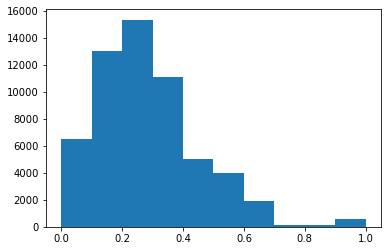

In [15]:
plt.hist(comorbidity['max_mortality'])

(array([7.6940e+03, 2.9277e+04, 1.7703e+04, 2.5470e+03, 2.7500e+02,
        6.3000e+01, 1.2000e+01, 8.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.0701144 , 0.14022879, 0.21034319, 0.28045758,
        0.35057198, 0.42068638, 0.49080077, 0.56091517, 0.63102956,
        0.70114396]),
 <BarContainer object of 10 artists>)

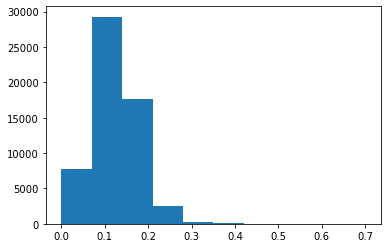

In [16]:
plt.hist(comorbidity['mean_mortality'])

In [17]:
# Merge variables proxying the mortality associated with each ICD9 code back to main dataframe
df = pd.merge(left=data, 
                right=mortality_proxy[['ICD9_diagnosis', 'mortality_proxy']],
                how='left', on='ICD9_diagnosis')

df_test = pd.merge(left=data_test, 
                right=mortality_proxy[['ICD9_diagnosis', 'mortality_proxy']],
                how='left', on='ICD9_diagnosis')

print(df.shape)
print(df_test.shape)

(20885, 45)
(5221, 40)


In [18]:
# Merge mean and max mortality from comorbidities for each patient back to main dataframe
df = pd.merge(left=df, 
                right=comorbidity[['subject_id', 'hadm_id', 'max_mortality', 'mean_mortality']],
                how='left', on=['subject_id', 'hadm_id'])

df_test = pd.merge(left=df_test, 
                right=comorbidity[['subject_id', 'hadm_id', 'max_mortality', 'mean_mortality']],
                how='left', on=['subject_id', 'hadm_id'])

print(df.shape)
print(df_test.shape)

(20885, 47)
(5221, 42)


In [19]:
df.head()
#df_test.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS,mortality_proxy,max_mortality,mean_mortality
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,0.197044,0.298851,0.130240
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582,0.000000,0.151316,0.059211
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626,0.200000,0.308642,0.173482
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734,0.083784,0.254300,0.110512
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654,0.112150,0.690616,0.138761


## Data Exploration

In [20]:
# Drop id columns
df = df.drop(columns=['subject_id', 'hadm_id', 'icustay_id'])
df_test = df_test.drop(columns=['subject_id', 'hadm_id', 'icustay_id'])
df.info()
#df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 0 to 20884
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   HeartRate_Min         18698 non-null  float64
 2   HeartRate_Max         18698 non-null  float64
 3   HeartRate_Mean        18698 non-null  float64
 4   SysBP_Min             18677 non-null  float64
 5   SysBP_Max             18677 non-null  float64
 6   SysBP_Mean            18677 non-null  float64
 7   DiasBP_Min            18676 non-null  float64
 8   DiasBP_Max            18676 non-null  float64
 9   DiasBP_Mean           18676 non-null  float64
 10  MeanBP_Min            18699 non-null  float64
 11  MeanBP_Max            18699 non-null  float64
 12  MeanBP_Mean           18699 non-null  float64
 13  RespRate_Min          18696 non-null  float64
 14  RespRate_Max          18696 non-null  float64
 15  RespRate_Mean      

In [21]:
# Find columns in test data that are not in train data
cols_diff = df.columns.difference(df_test.columns)
print(cols_diff)

cols_diff = cols_diff.drop('HOSPITAL_EXPIRE_FLAG')
print(cols_diff)

Index(['DEATHTIME', 'DISCHTIME', 'DOD', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')
Index(['DEATHTIME', 'DISCHTIME', 'DOD', 'LOS'], dtype='object')


In [22]:
# Drop columns that do not feature in both test and train data
print(df.columns)
print(df_test.columns)

df.drop(columns = cols_diff, inplace=True)
#df.info()

Index(['HOSPITAL_EXPIRE_FLAG', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB', 'DOD',
       'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS', 'mortality_proxy',
       'max_mortality', 'mean_mortality'],
      dtype='object')
Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max

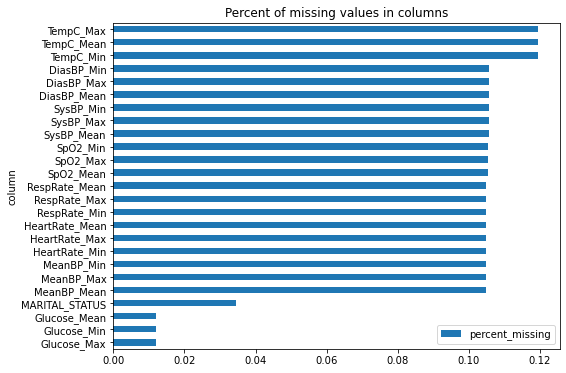

In [23]:
#Look at missing values
def plot_missing_values(df):
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    missing.plot(kind='barh', x='column', y='percent_missing', figsize=(8,6)); 
    plt.title('Percent of missing values in columns');

plot_missing_values(df)
# Note: except for "MARITAL_STATUS" only numerical features have missing data

In [24]:
cols = df.columns
cols

Index(['HOSPITAL_EXPIRE_FLAG', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'mortality_proxy', 'max_mortality', 'mean_mortality'],
      dtype='object')

In [25]:
num_feat = df.select_dtypes(exclude=['object', 'category']).columns
num_feat

num_main = num_feat[:26]
num_comor = num_feat[26:]

In [26]:
df[num_feat].describe()

,HOSPITAL_EXPIRE_FLAG,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,mortality_proxy,max_mortality,mean_mortality
count,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,18676.000000,18676.000000,...,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000,20885.000000,20885.000000
mean,0.112282,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,88.360784,62.511614,...,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,0.156045,0.331381,0.135650
std,0.315720,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,19.285554,11.010790,...,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,0.115577,0.165367,0.042956
min,0.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,...,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.000000,0.000000,0.000000
25%,0.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,75.000000,54.950952,...,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,0.083333,0.207607,0.107882
50%,0.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,86.000000,61.423660,...,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,0.133399,0.298851,0.129941
75%,0.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,98.000000,68.954545,...,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,0.217391,0.419118,0.156834
max,1.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,294.000000,121.489362,...,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,1.000000,1.000000,0.701144


<function matplotlib.pyplot.show(close=None, block=None)>

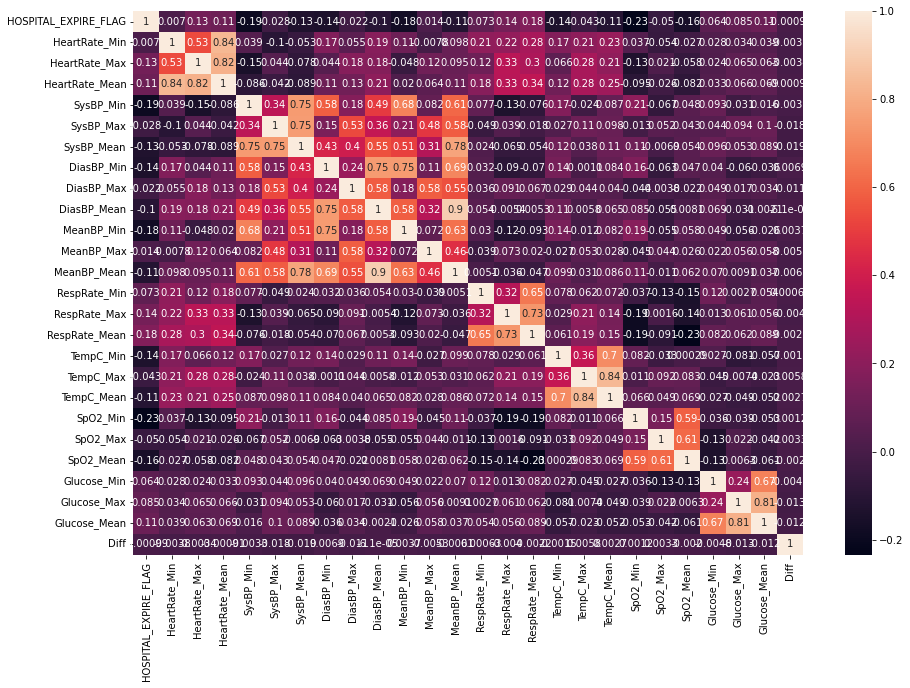

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df[num_main].corr(), annot=True)
plt.show

In [28]:
cat_feat = df.select_dtypes(include=['object', 'category']).columns
cat_feat

Index(['GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [29]:
for col in cat_feat:
    print(df[col].value_counts())

M    11759
F     9126
Name: GENDER, dtype: int64
2117-08-07 00:00:00    26
2096-10-22 00:00:00    16
2112-11-14 00:00:00    16
2105-05-05 00:00:00    15
2144-09-28 00:00:00    15
                       ..
2097-11-11 00:00:00     1
2110-12-16 00:00:00     1
1895-07-20 00:00:00     1
2137-12-05 00:00:00     1
2143-05-24 00:00:00     1
Name: DOB, Length: 14007, dtype: int64
2165-02-25 11:40:00    5
2150-11-03 22:05:00    5
2169-10-31 20:11:00    5
2177-04-13 17:36:00    4
2176-02-27 17:39:00    4
                      ..
2170-06-03 20:01:00    1
2122-05-22 15:15:00    1
2170-01-19 22:02:00    1
2150-06-19 03:23:00    1
2189-02-19 07:15:00    1
Name: ADMITTIME, Length: 19714, dtype: int64
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: ADMISSION_TYPE, dtype: int64
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: INSURANCE, dtype: int64
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER     

## Feature Manipulation

The Age variable is created manually, all other features will be processed within a pipeline.

### Make an Age variable
The AGE variable is created using the DOB and ADMITTIME variables. I subtract the difference given by the Diff column in order to get dates that have a real meaning. Then I calculate the time difference between these two dates in order to determine the age of an individual. Note that individuals older than 89 are encoded as 300. We thus have observations with age>300. In order to account for this, I group individuals into age groups. The following age groups are used:
+ 15-19 years 
+ 20-29 years
+ 30-39 years
+ 40-49 years
+ 50-59 years
+ 60-69 years
+ 70-79 years
+ 80-89 years
+ 90+ years

In [30]:
# Convert the date columns to datetime format
df['DOB']= pd.to_datetime(df['DOB'], format='%Y-%m-%d')
df['ADMITTIME']= pd.to_datetime(df['ADMITTIME'], format='%Y-%m-%d')

df_test['DOB']= pd.to_datetime(df_test['DOB'], format='%Y-%m-%d')
df_test['ADMITTIME']= pd.to_datetime(df_test['ADMITTIME'], format='%Y-%m-%d')

# Add difference to make datetimes realistic
from datetime import timedelta
df['DOB'] = df['DOB'] + pd.to_timedelta(df.Diff, unit="d")
df['ADMITTIME'] = df['ADMITTIME'] + pd.to_timedelta(df.Diff, unit="d")

df_test['DOB'] = df_test['DOB'] + pd.to_timedelta(df_test.Diff, unit="d")
df_test['ADMITTIME'] = df_test['ADMITTIME'] + pd.to_timedelta(df_test.Diff, unit="d")

df[['DOB', 'ADMITTIME']].head()
df_test[['DOB', 'ADMITTIME']].head()

,DOB,ADMITTIME
0,1929-11-30 13:44:32.640000000,2011-06-19 01:29:32.640000000
1,1961-10-10 21:56:56.256000001,2010-02-27 21:54:56.256000001
2,1967-04-27 09:11:19.104000000,2009-07-02 16:26:19.104000000
3,1927-12-20 10:57:53.568000000,2012-04-07 07:57:53.568000000
4,1957-03-19 01:33:46.368000000,2010-03-17 23:38:46.368000000


<AxesSubplot:xlabel='AGE', ylabel='Count'>

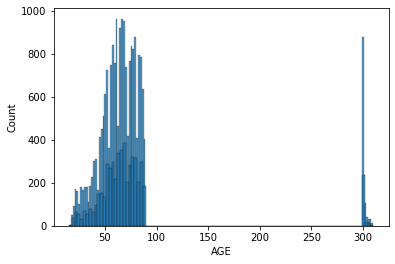

In [31]:
# Create an age variable: I use the naive approach where we subtract years
df['YOB'] = df['DOB'].dt.strftime('%Y').astype(int)
df['YADMIT'] = df['ADMITTIME'].dt.strftime('%Y').astype(int)
df['AGE'] = df['YADMIT'] - df['YOB']

df_test['YOB'] = df_test['DOB'].dt.strftime('%Y').astype(int)
df_test['YADMIT'] = df_test['ADMITTIME'].dt.strftime('%Y').astype(int)
df_test['AGE'] = df_test['YADMIT'] - df_test['YOB']

#print(df['AGE'].describe())
#print(df_test['AGE'].describe())

# Plot distribution of age
sns.histplot(data=df, x="AGE")
sns.histplot(data=df_test, x="AGE")
# there are observations with AGE > 300.

<AxesSubplot:xlabel='AGEGROUP', ylabel='Count'>

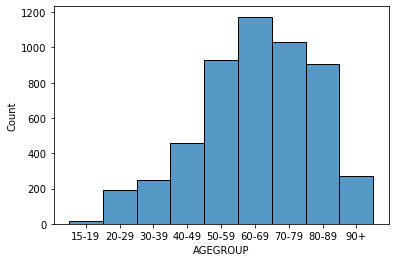

In [32]:
# Make age groups
bins= [15,20,30,40,50,60,70,80,90,400]
labels = ['15-19','20-29','30-39','40-49','50-59', '60-69', '70-79', '80-89', '90+']

df['AGEGROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)
df_test['AGEGROUP'] = pd.cut(df_test['AGE'], bins=bins, labels=labels, right=False)


# delete variables related to age
df = df.drop(columns=['DOB', 'YOB', 'ADMITTIME', 'YADMIT', 'Diff', 'AGE'])
df_test = df_test.drop(columns=['DOB', 'YOB', 'ADMITTIME', 'YADMIT', 'Diff', 'AGE'])

#sns.histplot(data=df, x="AGEGROUP")
sns.histplot(data=df_test, x="AGEGROUP")

## Set up preprocessing steps of pipeline

The pipeline differentiates between numerical and categorical features as these need to be dealt with differently during preprocessing. Missing values need to be imputed for both, but the imputation techniques can differ. Furthermore, numerical features need to be scaled, whilst categorical variables require one hot encoding. From the data exploration we know that mainly numerical columns have missing data. There is only one categorical feature, marital status, for which missing values need to be imputed. For simplicity, I thus decided to impute missing values for marital status by taking the mode with the Simple Imputer. For the imputation of numerical data I tried different Iterative Imputers which either showed convergence warnings, didn't run or did not improve the outcome:

+ ```IterativeImputer(BayesianRidge())``` - convergence warning and worse outcome
+ ```IterativeImputer(initial_strategy='median', random_state=2, estimator=KNeighborsRegressor(n_neighbors=3), max_iter=60, add_indicator=False)``` - convergence warning
+ ```ExtraTreesRegressor(n_estimators=20, random_state=0)``` - still running after 20+ hours
+ ```DecisionTreeRegressor(max_features="sqrt", random_state=0)``` - does not run

Ultimately, I decided to stick with imputing missing values with the mean using the Simple Imputer as the results were no worse and there was a large efficiency gain.

In [33]:
# Update list of numerical and categorical features
num_feat_clean = df.select_dtypes(exclude=['object', 'category']).columns
num_feat_clean = num_feat_clean.drop(['HOSPITAL_EXPIRE_FLAG'])
print(num_feat_clean)

cat_feat_clean = df.select_dtypes(include=['object', 'category']).columns

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat_clean = ['ICD9_diagnosis']
cat_feat_clean = cat_feat_clean.drop(['ICD9_diagnosis']) 
print(icd9_feat_clean)
print(cat_feat_clean)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'mortality_proxy', 'max_mortality', 'mean_mortality'],
      dtype='object')
['ICD9_diagnosis']
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'AGEGROUP'],
      dtype='object')


In [34]:
# pipeline for numerical data
num_preprocessing = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler())

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse=False))

icd9_preprocessing = make_pipeline(
    ce.BinaryEncoder())
    #OneHotEncoder(handle_unknown="ignore", sparse=False))


# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat_clean),
     ("cat", cat_preprocessing, cat_feat_clean),
     ("icd9", icd9_preprocessing, icd9_feat_clean)]
)

In [35]:
X_train, y_train = df.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1), df['HOSPITAL_EXPIRE_FLAG']
X_test = df_test

In [36]:
y_train.value_counts()

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

# K-Nearest Neighbours
The model performs perfectly insample even when I run a simple KNN. This can be attributed to the fact that I target encode the comorbidities based on the hospital expiry flag from the training dataset. I thus predict y based on a variable that was constructed using that same y. As a consequence, I drastically overfit the model. I attempt to reduce overfitting in my hyperparameter tuning by running a grid search over a large range of numbers for the number of neighbours. However, this does not have the desired effect (AUC = accuracy = 1.0). Cross validation is unable to solve the problem as including the mortality proxies reduces the independent variation in y. There is thus no gain to be made from hyperparameter tuning and class imbalance correction. I demonstrate the steps nonetheless, but no effect can be seen in terms of AUC, accuracy scores and the confusion matrix.

### Pipeline for simple model
For this simple model I will define the number of neighbours according to the following rule of thumb: k = sqrt(N). This was termed the "general practice" in this article: https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e.

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


--- 396.8143289089203 seconds ---
Accuracy Score : 1.0
AUC:  1.0


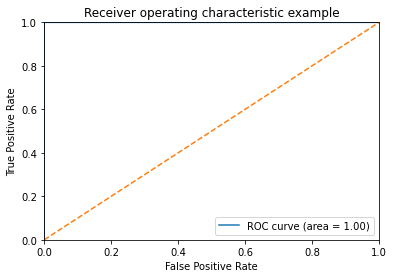

In [37]:
start_time = time.time()

pipeline_knn_simple = Pipeline(
    [("preprocess", preprocessing),
     ("knn_regressor", KNeighborsClassifier(weights='distance', p=2, metric='minkowski', n_neighbors=150))]
)

pipeline_knn_simple.fit(X_train, y_train)

y_pred_train_knn_simple = pipeline_knn_simple.predict(X_train)
y_pred_test_knn_simple = pipeline_knn_simple.predict(X_test)

y_prob_train_knn_simple = pipeline_knn_simple.predict_proba(X_train)
y_prob_test_knn_simple = pipeline_knn_simple.predict_proba(X_test)

print("--- %s seconds ---" % (time.time() - start_time))
print('Accuracy Score : '+ str(accuracy_score(y_train, y_pred_train_knn_simple)))
get_auc(y_train, y_prob_train_knn_simple, class_labels=[0,1])

Confusion matrix


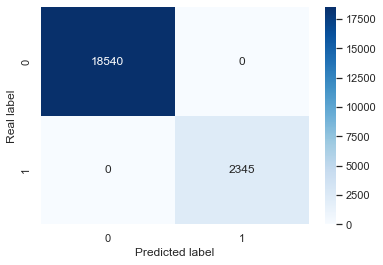

In [38]:
# Plot Confusion matrix (in-sample)
print("Confusion matrix")
cm_knn_simple = confusion_matrix(y_train, y_pred_train_knn_simple)
plot_confusion_matrix(cm_knn_simple, [0, 1])

### Pipeline for hyperparameter tuning

I only use the Minkowski and Hamming distance in my GridSearch. By changing the parameter p between 1 and 2, I am able to obtain the Manhattan (p=1) and Euclidean (p=2) distance metrics from the Minkowski distance respectively.  The GridSearch focuses on the number of neighbours as the main hyperparameter of interest. As can be seen below, there does not seem to be a convergence to a certain number of neighbours. Instead the GridSearch always yields the value at the upper end of the range of numbers. This I attribute to the reasons given above. This GridSearch is thus not useful for finding the optimal hyperparameters.

In [39]:
# Pipeline for hyperparameter tuning
start_time = time.time()

pipeline_knn = Pipeline(
    [("preprocess", preprocessing),
     ("knn_regressor", KNeighborsClassifier(weights='distance'))]
)

parameters_knn = {
    #'knn_regressor__n_neighbors': [1, 5, 10, 20, 30, 40], # n=40
    #'knn_regressor__n_neighbors': [10, 50, 100, 150, 200], # n=200
    'knn_regressor__n_neighbors': [100, 200, 300, 400, 500], # Warnings after n_neighbours > 500
    'knn_regressor__metric': ['minkowski', 'hamming'],
    'knn_regressor__p': [1, 2],
}

# instantiate GridSearch with pipeline
#grid_knn = RandomizedSearchCV(pipeline_knn, parameters_knn, scoring='roc_auc', n_iter=10, cv=5)
grid_knn = HalvingGridSearchCV(pipeline_knn, parameters_knn, scoring='roc_auc', cv=5)

grid_knn.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Best parameter (CV score=%0.3f):" % grid_knn.best_score_)
print(grid_knn.best_params_)

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

--- 10895.095766067505 seconds ---
Best parameter (CV score=0.922):
{'knn_regressor__metric': 'minkowski', 'knn_regressor__n_neighbors': 500, 'knn_regressor__p': 2}


In [40]:
y_pred_train_knn = grid_knn.predict(X_train)
y_pred_test_knn = grid_knn.predict(X_test)

y_prob_train_knn = grid_knn.predict_proba(X_train)
y_prob_test_knn = grid_knn.predict_proba(X_test)

Accuracy Score : 1.0
AUC:  1.0


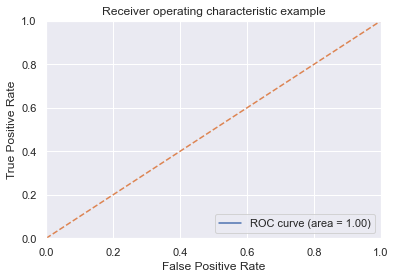

In [41]:
# Compute different evaluation metrics (in-sample)
print('Accuracy Score : ' + str(accuracy_score(y_train, y_pred_train_knn)))
get_auc(y_train, y_prob_train_knn, class_labels=[0,1])

Confusion matrix


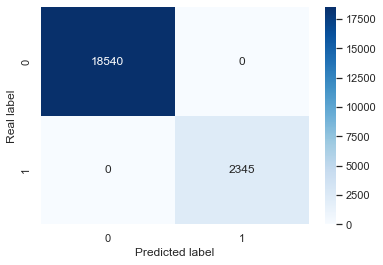

In [42]:
# Plot Confusion matrix (in-sample)
print("Confusion matrix")
cm_knn = confusion_matrix(y_train, y_pred_train_knn)
plot_confusion_matrix(cm_knn, [0, 1])

### Correcting for Class Imbalance
Given that cross validation did not prove useful in addressing overfitting and finding the optimum number of neighbours, I will stick to k=150 to provide an example of how one could address class imbalance.

In [43]:
# resampling methods to compare
smt = SMOTE(random_state=42)
over1 = RandomOverSampler(random_state=42, sampling_strategy='minority')
over2 = RandomOverSampler(random_state=42, sampling_strategy=0.5)
under1 = RandomUnderSampler(random_state=42, sampling_strategy='majority')
under2 = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
mixed = (RandomOverSampler(random_state=42, sampling_strategy=0.2), RandomUnderSampler(random_state=42, sampling_strategy=0.4))


# build for loop that iterates through different methods and compares them
resamplers = [smt, over1, over2, under1, under2, mixed]

index = []
scores = {"AUC": [], "Accuracy": []}

start_time = time.time()

for resampler in resamplers:
    
    if resampler != mixed:
    
        pipeline_knn_cimb = Pipeline(
            [("preprocess", preprocessing),
             ("resample", resampler),
             ("knn_regressor", KNeighborsClassifier(weights='distance', p=2, metric='minkowski', n_neighbors=150))]
        )
   
    else:
        pipeline_knn_cimb = Pipeline(
            [("preprocess", preprocessing),
             ("oversample", resampler[0]),
             ("undersample", resampler[1]),
             ("knn_regressor", KNeighborsClassifier(weights='distance', p=2, metric='minkowski', n_neighbors=150))]
        )

    pipeline_knn_cimb.fit(X_train, y_train)

    y_pred_train_knn_cimb = pipeline_knn_cimb.predict(X_train)
    y_prob_train_knn_cimb = pipeline_knn_cimb.predict_proba(X_train)
    
    index += [resampler]
    scores["AUC"].append(roc_auc_score(y_train, y_prob_train_knn_cimb[:,1]))
    scores["Accuracy"].append(accuracy_score(y_train, y_pred_train_knn_cimb))


df_scores = pd.DataFrame(scores, index=index)
print(df_scores)

print("--- %s seconds ---" % (time.time() - start_time))

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

                                                    AUC  Accuracy
SMOTE(random_state=42)                              1.0  1.000000
RandomOverSampler(random_state=42, sampling_str...  1.0  1.000000
RandomOverSampler(random_state=42, sampling_str...  1.0  1.000000
RandomUnderSampler(random_state=42, sampling_st...  1.0  0.902753
RandomUnderSampler(random_state=42, sampling_st...  1.0  0.979746
(RandomOverSampler(random_state=42, sampling_st...  1.0  0.988939
--- 13111.075836896896 seconds ---


In [44]:
# All oversampling techniques perform equally well and have no effect on AUC and accuracy.
# I use the RandomOverSampler with sampling_strategy=0.5 to make my predictions
pipeline_knn_cimb = Pipeline(
    [("preprocess", preprocessing),
     ("resample", over2),
     ("knn_regressor", KNeighborsClassifier(weights='distance', p=2, metric='minkowski', n_neighbors=150))]
)

pipeline_knn_cimb.fit(X_train, y_train)

y_pred_train_knn_cimb = pipeline_knn_cimb.predict(X_train)
y_pred_test_knn_cimb = pipeline_knn_cimb.predict(X_test)

y_prob_train_knn_cimb = pipeline_knn_cimb.predict_proba(X_train)
y_prob_test_knn_cimb = pipeline_knn_cimb.predict_proba(X_test)

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


Accuracy Score : 1.0
AUC:  1.0


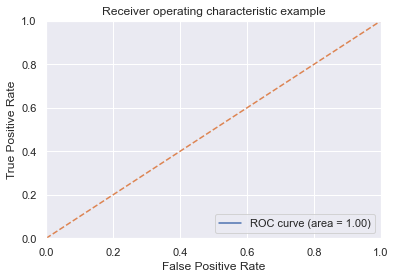

In [45]:
# Compute different evaluation metrics (in-sample)
print('Accuracy Score : ' + str(accuracy_score(y_train, y_pred_train_knn_cimb)))
get_auc(y_train, y_prob_train_knn_cimb, class_labels=[0,1])

Confusion matrix


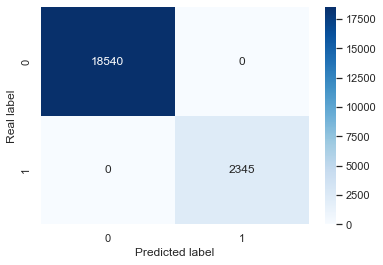

In [46]:
# Plot Confusion matrix (in-sample)
print("Confusion matrix")
cm_knn_cimb = confusion_matrix(y_train, y_pred_train_knn_cimb)
plot_confusion_matrix(cm_knn_cimb, [0, 1])

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [47]:
# Produce .csv for kaggle testing 
#test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_prob_test_knn_simple[:,1]})
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_prob_test_knn[:,1]})
#test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_prob_test_knn_cimb[:,1]})

test_predictions_submit.to_csv("kaggle/test_predictions_submit_knn.csv", index = False)

# Support Vector Classifier
This model took ages for me to run. I repeatedly interrupted my kernel after 24+ hours. In order to avoid these computational constraints, I decided to subset my data to roughly 25% of its original size (5000 observations). All SVC models will be trained on this subset of data.

### Pipeline for simple model

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


--- 40.39071989059448 seconds ---
Accuracy Score : 0.9291836246109648
AUC:  0.9378890222949055


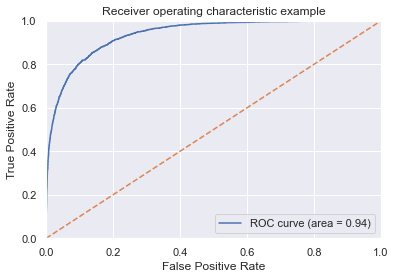

In [48]:
start_time = time.time()

pipeline_svc_simple = Pipeline(
    [("preprocess", preprocessing),
     ("svc_regressor", SVC(kernel='linear', C=0.1, probability=True))]
)

pipeline_svc_simple.fit(X_train[:5000], y_train[:5000])

y_pred_train_svc_simple = pipeline_svc_simple.predict(X_train)
y_pred_test_svc_simple = pipeline_svc_simple.predict(X_test)

y_prob_train_svc_simple = pipeline_svc_simple.predict_proba(X_train)
y_prob_test_svc_simple = pipeline_svc_simple.predict_proba(X_test)

print("--- %s seconds ---" % (time.time() - start_time))
print('Accuracy Score : '+ str(accuracy_score(y_train, y_pred_train_svc_simple)))
get_auc(y_train, y_prob_train_svc_simple, class_labels=[0,1])

Confusion matrix


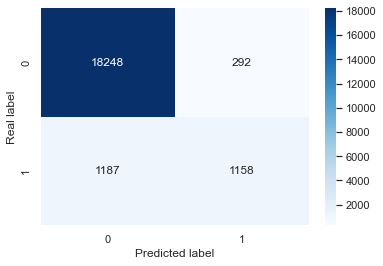

In [49]:
# Plot Confusion matrix (in-sample)
print("Confusion matrix")
cm_svc_simple = confusion_matrix(y_train, y_pred_train_svc_simple)
plot_confusion_matrix(cm_svc_simple, [0, 1])

### Pipeline for hyperparameter tuning

In [50]:
start_time = time.time()

parameters_svc = {
    #'svc_regressor__C':[0.1, 1, 10],
    'svc_regressor__C':[0.001, 0.01, 0.1, 1],
    'svc_regressor__kernel':['linear', 'rbf']
}

pipeline_svc = Pipeline(
    [("preprocess", preprocessing),
     ("svc_regressor", SVC(probability=True))]
)

# instantiate GridSearch with pipeline
#grid_svc = RandomizedSearchCV(pipeline_svc, parameters_svc, scoring='roc_auc', n_iter=3, cv=5)
grid_svc = HalvingGridSearchCV(pipeline_svc, parameters_svc, scoring='roc_auc', cv=5)

grid_svc.fit(X_train[:5000], y_train[:5000])

print("--- %s seconds ---" % (time.time() - start_time))
print("Best parameter (CV score=%0.3f):" % grid_svc.best_score_)
print(grid_svc.best_params_)

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

--- 241.59268617630005 seconds ---
Best parameter (CV score=0.923):
{'svc_regressor__C': 0.1, 'svc_regressor__kernel': 'linear'}


In [51]:
#Predict values based on optimized parameters
y_pred_train_svc = grid_svc.predict(X_train)
y_pred_test_svc = grid_svc.predict(X_test)

y_prob_train_svc = grid_svc.predict_proba(X_train)
y_prob_test_svc = grid_svc.predict_proba(X_test)

Accuracy Score : 0.9291836246109648
AUC:  0.9378930589769598


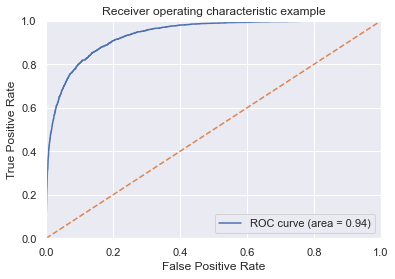

In [52]:
# Compute different Evaluation metrics (in-sample)
print('Accuracy Score : '+ str(accuracy_score(y_train, y_pred_train_svc)))
get_auc(y_train, y_prob_train_svc, class_labels=[0,1])

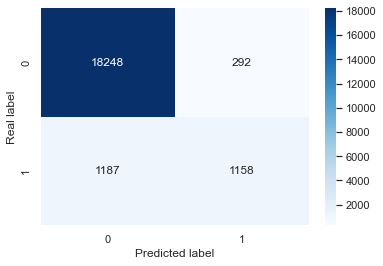

In [53]:
# Confusion matrix
cm_svc = confusion_matrix(y_train, y_pred_train_svc)
plot_confusion_matrix(cm_svc, [0, 1])

### Correcting for class imbalance

In [54]:
# resampling methods to compare
smt = SMOTE(random_state=42)
over1 = RandomOverSampler(random_state=42, sampling_strategy='minority')
over2 = RandomOverSampler(random_state=42, sampling_strategy=0.5)
under1 = RandomUnderSampler(random_state=42, sampling_strategy='majority')
under2 = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
mixed = (RandomOverSampler(random_state=42, sampling_strategy=0.2), RandomUnderSampler(random_state=42, sampling_strategy=0.4))


# build for loop that iterates through different methods and compares them
resamplers = [smt, over1, over2, under1, under2, mixed]

index = []
scores = {"AUC": [], "Accuracy": []}

start_time = time.time()

for resampler in resamplers:
    
    if resampler != mixed:
    
        pipeline_svc_cimb = Pipeline(
            [("preprocess", preprocessing),
             ("resample", resampler),
             ("svc_regressor", SVC(kernel='linear', C=0.01, probability=True))]
        )
   
    else:
        pipeline_svc_cimb = Pipeline(
            [("preprocess", preprocessing),
             ("oversample", resampler[0]),
             ("undersample", resampler[1]),
             ("svc_regressor", SVC(kernel='linear', C=0.01, probability=True))]
        )

    pipeline_svc_cimb.fit(X_train[:5000], y_train[:5000])

    y_pred_train_svc_cimb = pipeline_svc_cimb.predict(X_train)
    y_prob_train_svc_cimb = pipeline_svc_cimb.predict_proba(X_train)
    
    index += [resampler]
    scores["AUC"].append(roc_auc_score(y_train, y_prob_train_svc_cimb[:,1]))
    scores["Accuracy"].append(accuracy_score(y_train, y_pred_train_svc_cimb))


df_scores = pd.DataFrame(scores, index=index)
print(df_scores)

print("--- %s seconds ---" % (time.time() - start_time))

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is

                                                         AUC  Accuracy
SMOTE(random_state=42)                              0.935633  0.855782
RandomOverSampler(random_state=42, sampling_str...  0.936625  0.857170
RandomOverSampler(random_state=42, sampling_str...  0.936748  0.901221
RandomUnderSampler(random_state=42, sampling_st...  0.930219  0.835001
RandomUnderSampler(random_state=42, sampling_st...  0.934139  0.905387
(RandomOverSampler(random_state=42, sampling_st...  0.936263  0.915011
--- 2725.3285450935364 seconds ---


In [55]:
# The mixed and RandomOverSampler with sampling_strategy=0.5 perform best in terms of AUC und accuracy.
# I try both to correct for class imbalance in my SVC model
# The RandomOverSampler seems to correct better for class imbalance

pipeline_svc_cimb = Pipeline(
    [("preprocess", preprocessing),
     ("resample", over2),
     #("oversample", mixed[0]),
     #("undersample", mixed[1]),
     ("svc_regressor", SVC(kernel='linear', C=0.01, probability=True))]
)

pipeline_svc_cimb.fit(X_train[:5000], y_train[:5000])

y_pred_train_svc_cimb = pipeline_svc_cimb.predict(X_train)
y_pred_test_svc_cimb = pipeline_svc_cimb.predict(X_test)

y_prob_train_svc_cimb = pipeline_svc_cimb.predict_proba(X_train)
y_prob_test_svc_cimb = pipeline_svc_cimb.predict_proba(X_test)

/Users/philine/miniconda3/envs/cml/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


Accuracy Score : 0.9012209719894662
AUC:  0.9367492173897044


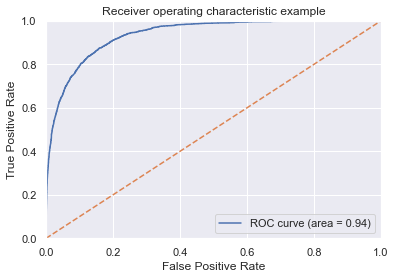

In [56]:
# Compute different Evaluation metrics (in-sample)
print('Accuracy Score : '+ str(accuracy_score(y_train, y_pred_train_svc_cimb)))
get_auc(y_train, y_prob_train_svc_cimb, class_labels=[0,1])

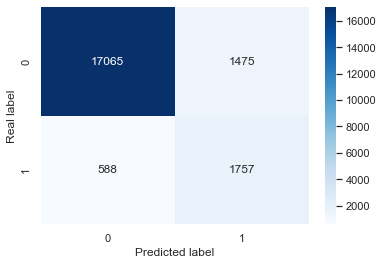

In [57]:
# Confusion matrix
cm_svc_cimb = confusion_matrix(y_train, y_pred_train_svc_cimb)
plot_confusion_matrix(cm_svc_cimb, [0, 1])

We can see that the mixed resampling has managed to address some of the class imbalance problem. AUC and accuracy are very similar across all three models.

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [58]:
# Produce .csv for kaggle testing 
#test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_prob_test_svc_simple[:,1]})
#test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_prob_test_svc[:,1]})
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_prob_test_svc_cimb[:,1]})

test_predictions_submit.to_csv("kaggle/test_predictions_submit_svm.csv", index = False)